# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "cs231n/assignments/assignment1/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
--2025-03-05 08:09:34--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  50.2MB/s    in 3.4s    

2025-03-05 08:09:38 (47.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/cs231n/assignments/assignment1


In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.360174
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to $-log(0.1)$? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ It expects our loss to be close to $-log(0.1)$, the reason is that: with random weights, the model's predictions are essentially random guesses.

In a classification problem with 10 classes, if the model has not learned anything and assigns equal probability to each class, the probability for the correct class would be approximately 0.1. The loss function used here is the cross-entropy loss, which for a single example with true label $ y $ and predicted probability $ p_y $ is given by $ -\log(p_y) $. If $ p_y = 0.1 $, then the loss would be $ -\log(0.1) \approx 2.3026$. This serves as a baseline to check if the loss is reasonable before any training has occurred.

With random weights, the model assigns approximately equal probability to each of the 10 classes. The expected loss is close to $-log(0.1)$ because the correct class has a probability of about 0.1, and the cross-entropy loss for this probability is $-log(0.1)$.



In [9]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.080408 analytic: 0.080408, relative error: 4.117212e-07
numerical: 0.667580 analytic: 0.667580, relative error: 8.101678e-08
numerical: 1.139377 analytic: 1.139377, relative error: 4.304391e-08
numerical: -0.565619 analytic: -0.565619, relative error: 5.863109e-08
numerical: -1.630414 analytic: -1.630414, relative error: 4.994217e-08
numerical: 1.593042 analytic: 1.593042, relative error: 1.127354e-08
numerical: 0.804008 analytic: 0.804008, relative error: 4.003464e-08
numerical: -0.919757 analytic: -0.919757, relative error: 1.501712e-09
numerical: -0.589818 analytic: -0.589818, relative error: 6.566720e-08
numerical: 1.383674 analytic: 1.383674, relative error: 5.198213e-09
numerical: 2.500708 analytic: 2.500708, relative error: 1.388971e-09
numerical: -0.090659 analytic: -0.090659, relative error: 6.224561e-07
numerical: -1.292699 analytic: -1.292699, relative error: 2.593231e-08
numerical: 2.830130 analytic: 2.830130, relative error: 2.350799e-08
numerical: -1.111680 a

In [10]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.360174e+00 computed in 0.282045s
vectorized loss: 2.360174e+00 computed in 0.031356s
Loss difference: 0.000000
Gradient difference: 0.000000


In [11]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from cs231n.classifiers.linear_classifier import Softmax
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate = lr, reg=rs, num_iters = 1500,
                     verbose = True)

        y_pred_train = softmax.predict(X_train)
        acc_train = np.mean(y_pred_train == y_train)

        y_pred_val = softmax.predict(X_val)
        acc_val = np.mean(y_pred_val == y_val)
        results[(lr, rs)] = (acc_train, acc_val)

        if acc_val > best_val:
            best_val = acc_val
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 385.855231
iteration 100 / 1500: loss 233.643650
iteration 200 / 1500: loss 142.016155
iteration 300 / 1500: loss 86.656998
iteration 400 / 1500: loss 53.070804
iteration 500 / 1500: loss 32.844895
iteration 600 / 1500: loss 20.742592
iteration 700 / 1500: loss 13.302495
iteration 800 / 1500: loss 8.876370
iteration 900 / 1500: loss 6.194712
iteration 1000 / 1500: loss 4.456591
iteration 1100 / 1500: loss 3.518034
iteration 1200 / 1500: loss 2.928798
iteration 1300 / 1500: loss 2.591128
iteration 1400 / 1500: loss 2.385156
iteration 0 / 1500: loss 771.008522
iteration 100 / 1500: loss 283.335866
iteration 200 / 1500: loss 105.107139
iteration 300 / 1500: loss 39.812391
iteration 400 / 1500: loss 15.873469
iteration 500 / 1500: loss 7.134221
iteration 600 / 1500: loss 3.954561
iteration 700 / 1500: loss 2.801751
iteration 800 / 1500: loss 2.365464
iteration 900 / 1500: loss 2.191793
iteration 1000 / 1500: loss 2.164963
iteration 1100 / 1500: loss 2.059939
iterat

In [12]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.359000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$
The statement means that the overall training loss is the sum of the loss for each individual training example. For the SVM loss, it is possible to add a new data point to the training set without changing the total loss. However, this is not the case with the Softmax classifier loss.
The SVM loss can remain unchanged when a new data point is added, but the Softmax loss will always change.

$\color{blue}{\textit Your Explanation:}$

- **SVM Loss:**
The SVM loss is based on the hinge loss, which is defined as the sum of the margins for each training example. The margin for a data point is the difference between the score of the correct class and the score of the incorrect classes. If a new data point is added that does not affect the margins of the existing data points, the total loss can remain unchanged. For example, if the new data point's scores for all classes are such that the margin conditions are already satisfied, the loss will not change.

- **Softmax Loss:**
The Softmax loss is based on the cross-entropy loss, which is computed using the probabilities derived from the scores of each class. The probability of each class is calculated using the softmax function, which normalizes the scores into a probability distribution. Adding a new data point will change the scores and thus the probabilities for all classes. This change in probabilities will affect the cross-entropy loss for all data points, including the new one. So, the total loss will always change when a new data point is added.



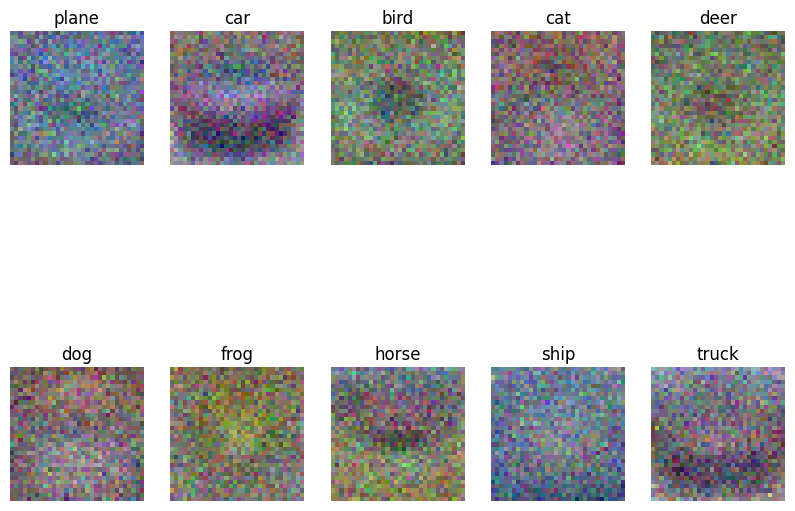

In [13]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])